## Imports
---

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from model.layer import GLVQ, GLMVQ
import os

In [24]:
!pip install nina-helper

  Using cached nina_helper-2.4-py3-none-any.whl.metadata (372 bytes)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

# Preprocessing
---

In [ ]:
import os
import torch
from scipy.io import loadmat

def list_files(directory, fileformat):
    """
    Return all file paths from a folder
    """
    mat_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(fileformat):
                mat_files.append(os.path.join(root, file).replace("\\", "/"))
    return mat_files

mat_files = list_files("data/ninapro", ".mat")

def preprocess(X):
    # Standardization
    scaler = StandardScaler()
    X = np.array([scaler.fit_transform(channel.T).T for channel in X])
    return X

def to_tensors(X, y):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def load_ninapro_data(mat_files):
    X_list, y_list = [], []

    for filename in mat_files:
        mat_data = loadmat(filename)
        
        # Ensure required keys exist
        if 'emg' in mat_data and 'restimulus' in mat_data:
            X = mat_data['emg'] 
            y = mat_data['restimulus'].flatten()

            # Align dimensions of X and y
            min_len = min(len(X), len(y))
            X = X[:min_len]
            y = y[:min_len]
            
            # Remove datapoints where no movement is being performed
            valid_idx = y > 0
            X = X[valid_idx]
            y = y[valid_idx]
            
            X_list.append(X)
            y_list.append(y)
        else:
            print(f"Missing keys in file: {filename}")

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    return to_tensors(X, y)

ninapro_folder = "data/ninapro"
mat_files = list_files(ninapro_folder, ".mat")

X_ninapro, y_ninapro = load_ninapro_data(mat_files)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 12 has size 12

In [ ]:
# Preprocessing step (we are going to skip the outlier removal and only use standardization)
def preprocess(X):
    # Reshape X to (n_samples, n_channels, n_timepoints) for more information look into next illustration
    X = X.reshape(-1, 10, 512)
    # Standardization (Z-Score Normalization in this case)
    standard = StandardScaler()
    # Scales each channel independently from each other
    X = np.array([standard.fit_transform(channel.T).T for channel in X])
    
    return X

# Transforms the data into tensors
def to_tensors(X, y):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def load_ninapro_data():
    pass

# Reads in the first 2 files as training data and the last as test set
def load_nearlab_data(file_paths):
    X_train_list, y_train_list = [], []
    
    # Load the training data
    for train_file in file_paths[:2]:
        data = pd.read_csv(folder_path + train_file, header=None, skiprows=[0])
        # Input Values
        X = data.iloc[:, :5120].values
        # Class
        y = data.iloc[:, 5120].values
        y = y - 1
        X = preprocess(X)
        X_train_list.append(X)
        y_train_list.append(y)
    
    # Combine the trainingsdata
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    
    # Load the test data
    data = pd.read_csv(folder_path + file_paths[2], header=None, skiprows=[0])
    X_test = data.iloc[:, :5120].values # Values
    y_test = data.iloc[:, 5120].values  # Class
    y_test = y_test - 1
    X_test = preprocess(X_test)
    
    # Convert into pytorch tensors for the model
    X_train, y_train = to_tensors(X_train, y_train)
    X_test, y_test = to_tensors(X_test, y_test)
    return X_train, y_train, X_test, y_test

# Local Files (Create a data folder or change the path to use it please). 
# You can find the data here:
folder_path = "data/nearlab/normal/sbj1/"
files = ["Nearlab_sbj1_WL512_S128_r1.csv", "Nearlab_sbj1_WL512_S128_r2.csv", "Nearlab_sbj1_WL512_S128_r3.csv"]

X_train, y_train, X_test, y_test = load_nearlab_data(files)

10
10
10


# Model 
---

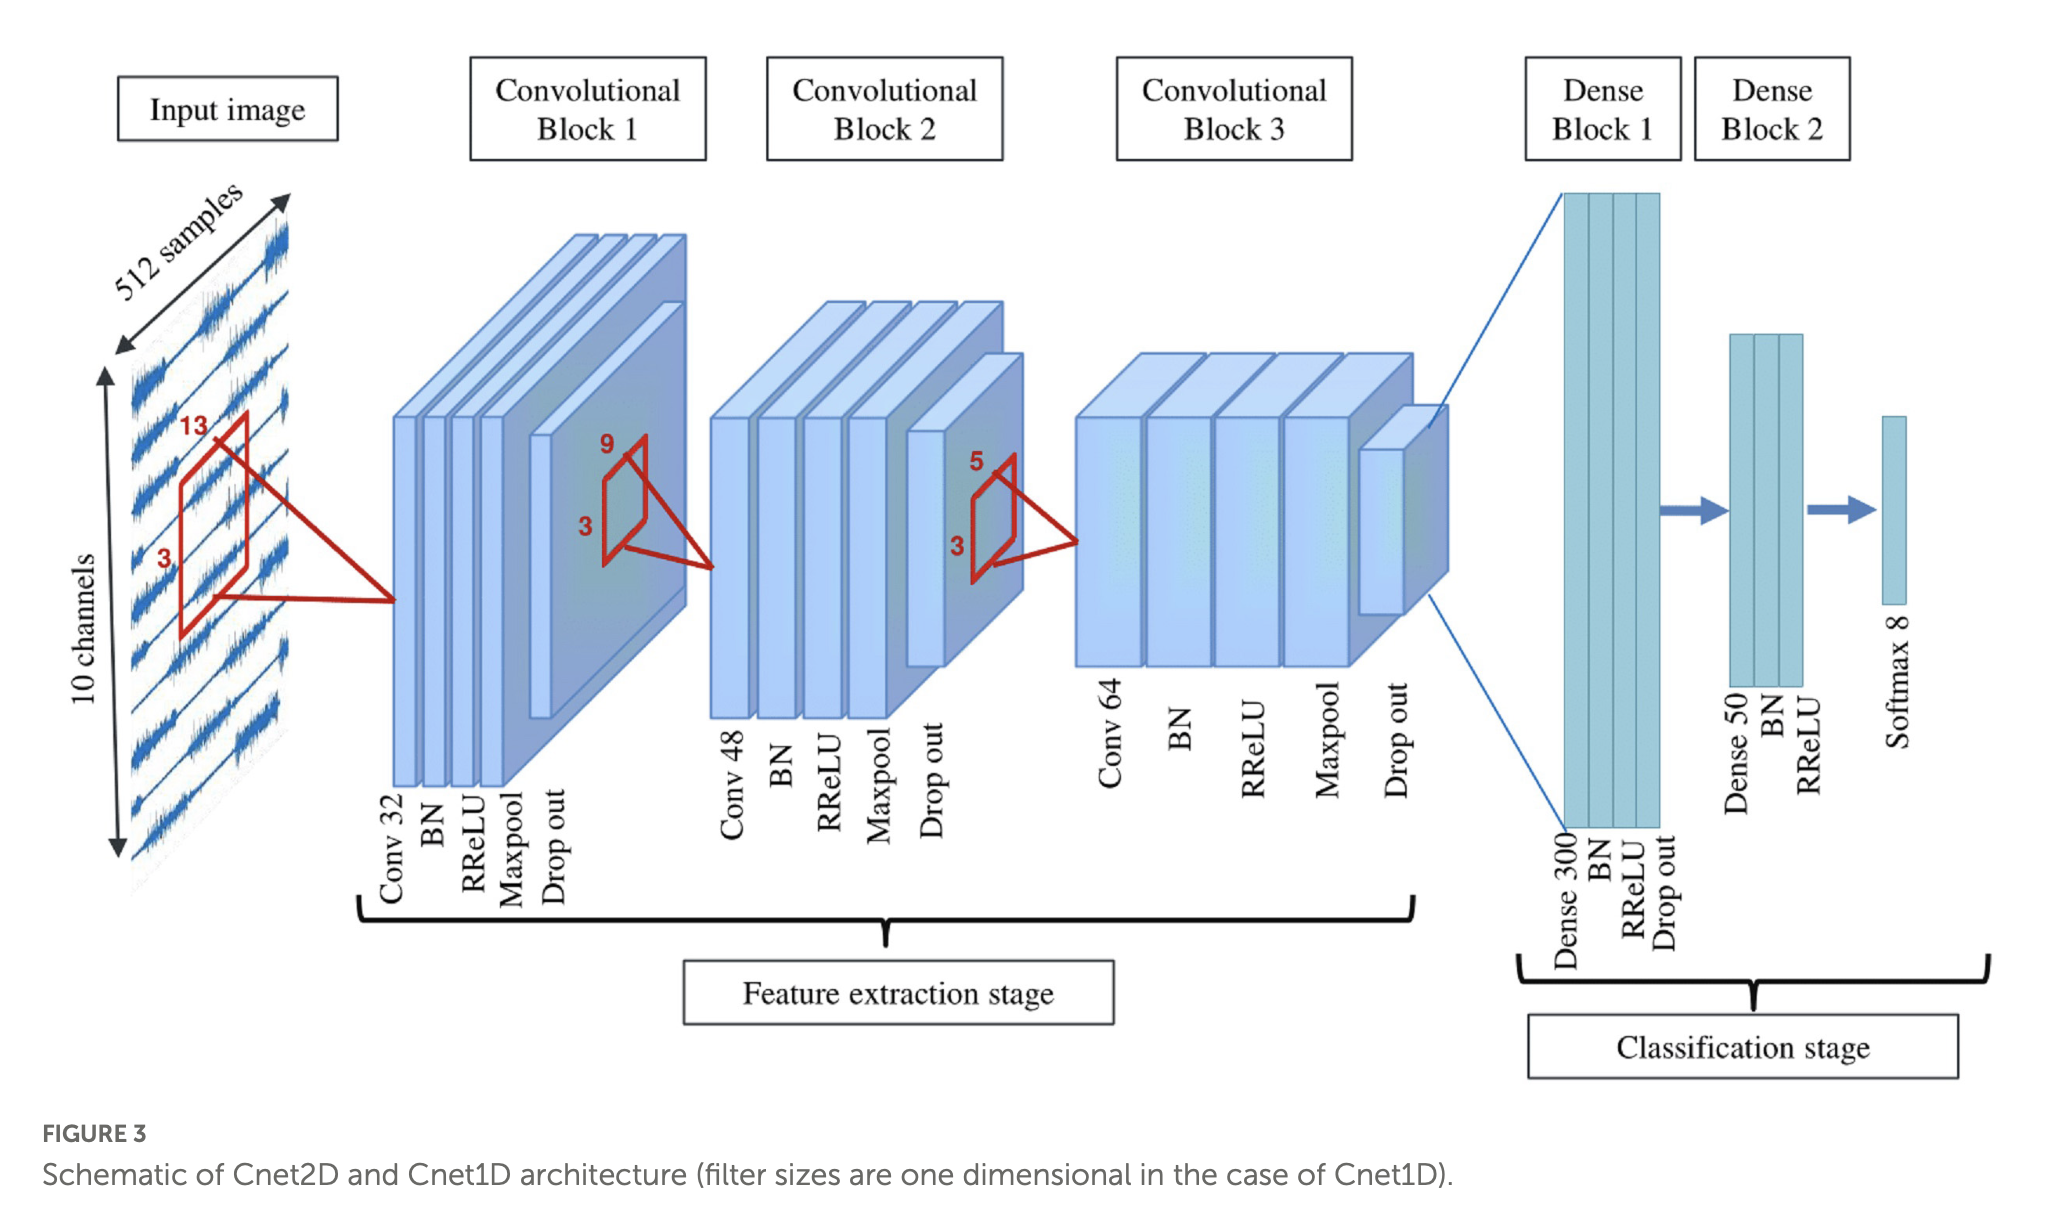

In [ ]:
version = "GLMVQ"
number_prototypes = 8

class CNet2D(nn.Module):
    def __init__(self):
        super(CNet2D, self).__init__()
        
        # Conv Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 13), padding=(1, 6))
        self.bn1 = nn.BatchNorm2d(32)
        self.rrelu1 = nn.RReLU()
        self.drop1 = nn.Dropout(0.3)
        
        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 48, kernel_size=(3, 9), padding=(1, 4))
        self.bn2 = nn.BatchNorm2d(48)
        self.rrelu2 = nn.RReLU()
        self.drop2 = nn.Dropout(0.3)
        
        # Conv Block 3
        self.conv3 = nn.Conv2d(48, 64, kernel_size=(3, 5), padding=(1, 2))
        self.bn3 = nn.BatchNorm2d(64)
        self.rrelu3 = nn.RReLU()
        self.drop3 = nn.Dropout(0.3)
        
        # Dense Block 1
        self.fc1 = nn.Linear(64 * 10 * 64, 300)
        self.fc_bn1 = nn.BatchNorm1d(300)
        self.fc_rrelu1 = nn.RReLU()
        self.fc_drop1 = nn.Dropout(0.3)
        
        # Dense Block 2 
        self.fc2 = nn.Linear(300, 50)
        self.fc_bn2 = nn.BatchNorm1d(50)
        self.fc_rrelu2 = nn.RReLU()
        if version == "Softmax":
            # Softmax Layer for classification
            self.fc3 = nn.Linear(50, 8)
        elif version == "GLVQ":
            self.fc3 = GLVQ(50, number_prototypes, 8)
        else:
            self.fc3 = GLMVQ(50, number_prototypes, 8)
        
    def forward(self, x, y=None):
        x = self.rrelu1(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, (1, 2))
        x = self.drop1(x)
        
        x = self.rrelu2(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, (1, 2))
        x = self.drop2(x)
        
        x = self.rrelu3(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, (1, 2))
        x = self.drop3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc_rrelu1(self.fc_bn1(self.fc1(x)))
        x = self.fc_drop1(x)
        x = self.fc_rrelu2(self.fc_bn2(self.fc2(x)))
        
        if version == "GLVQ":
            return x
        elif version == "GLMVQ":
            return x
        else:
            x = self.fc3(x)
            return F.log_softmax(x, dim=1)

# Training
---

In [ ]:
def train_model(model, X_train, y_train, epochs=1, batch_size=128, learning_rate=0.001, optimizer_type='ADAM', version='GLVQ'):
    # Reshape data
    def reshape_data(X):
        return X.reshape(X.shape[0], 1, -1, X.shape[-1])

    X_train = reshape_data(X_train)
    
    # Create dataset and loader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Init optimizer
    if optimizer_type == "ADAM":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type. Use 'adam' or 'sgd'.")

    # Training loop
    loss_epoch = []
    for epoch in range(epochs):
        model.train()
        epoch_losses = []

        for batch_X, batch_y in train_loader:
            # Reset Gradient
            optimizer.zero_grad()

            # GLVQ and GLMVQ Version
            if version == "GLVQ" or version == "GLMVQ":
                features = model(batch_X)
                # Forward pass through GLVQ layer
                loss = model.fc3(features, batch_y)
            else:  # Softmax version
                outputs = model(batch_X)
                loss = nn.CrossEntropyLoss()(outputs, batch_y)

            epoch_losses.append(loss.item())
            # Backward step
            loss.backward()
            # Update weights
            optimizer.step()

        avg_loss = np.mean(epoch_losses)
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss:.4f}')

    return model

model = CNet2D()
train_model(model, X_train, y_train, epochs=5, batch_size=64, learning_rate=0.001, optimizer_type='ADAM', version='GLVQ')

Epoch 1/5, Average Loss: 0.5988
Epoch 2/5, Average Loss: 0.4837
Epoch 3/5, Average Loss: 0.4597
Epoch 4/5, Average Loss: 0.4384
Epoch 5/5, Average Loss: 0.4208


CNet2D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 13), stride=(1, 1), padding=(1, 6))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rrelu1): RReLU(lower=0.125, upper=0.3333333333333333)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 48, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4))
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rrelu2): RReLU(lower=0.125, upper=0.3333333333333333)
  (drop2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(48, 64, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rrelu3): RReLU(lower=0.125, upper=0.3333333333333333)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=40960, out_features=300, bias=True)
  (fc_bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_rrelu1): RReLU(lower=0.125, upper=0.3

# Plotting
---

In [ ]:
# Need some more plotting here

# Evaluation
---

In [ ]:
model.eval()
with torch.no_grad():
    if version == "GLVQ":
        # Get features
        features = model(X_test)
        # Use GLVQ predict method
        predicted = model.fc3.predict(features)
    elif version == "GLMVQ":  
        # Use GLMVQ predict method
        features = model(X_test)
        predicted = model.fc3.predict(features)
    else:  # Softmax version
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
    
    # Calculate accuracy
    accuracy = (predicted == y_test).float().mean()
    print(f'Test Accuracy: {accuracy.item():.6f}')

Test Accuracy: 0.923138
